# Experiments for Stochastic Reformulation paper

In [115]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from tqdm import tqdm

In [116]:
# Plot display settings

#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 30#24
plt.rcParams['ytick.labelsize'] = 30#24
plt.rcParams['legend.fontsize'] = 36#24
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 42#36
plt.rcParams['axes.labelsize'] = 36#24

plt.rc('text', usetex=True)

# Ridge regression problem

Mathematical formulation:
$$ 
f(x) = \frac{1}{2 n} \sum_{i=1}^n (\langle a_i, x \rangle - y_i)^2 + \frac{\lambda}{2} \sum_{i=1}^n x_i^2 = 
\frac{1}{2 n} \| \mathbf{A} x - y \|_2^2 + \frac{\lambda}{2} \| x \|_2^2 
\to \min\limits_{x \in \mathbb{R}^d}
$$ 

In [8]:
def f_ridge(A, y, x, lambd):
    return la.norm(A @ x - y)**2 / (A.shape[0] * 2.0) + la.norm(x)**2 * lambd / 2.0

$$
f(x) = \frac{1}{n} \sum_{i=1}^n f_i(x),
$$ thus
$$
f_i(x) = \frac{1}{2} (A[i, :] x - y_i)^2 + \frac{\lambda}{2} \|x\|^2
$$

Solution to the optimization problem is:
$$
x^* = (A^T A + \lambda n I)^{-1} A^T y
$$

In [9]:
def solution(A, y, lambd):
    n = A.shape[0]
    d = A.shape[1]
    return np.dot(np.dot(la.inv(np.dot(A.T, A) + lambd * n * np.eye(d)), A.T), y)

Let
$$
f_v(x) = \frac{1}{n} \sum_{i=1}^n v_i f_i(x),
$$
where $\mathbb{E}(v)=1$

## SGD algorithm
$$
v^k \sim \cal{D} \\
x^{k+1} = x^k - \gamma^k \nabla f_{v^k} (x^k)
$$
Note that
$$
\nabla f_{v^k} (x^k) = \frac{1}{n} \sum_{i=1}^n v^k_i \nabla f_i(x^k)
$$
In our case, 
$$
\nabla f(x) = \frac{1}{n} A^T (Ax - y) + \lambda x,
$$
and
$$
\nabla f_i(x) = A[i, :]^T (A[i,:]x  - y_i) + \lambda x
$$


In [10]:
# Useful for further computations

# def grad_F(x):
#     return A.T @ (A @ x - y) / n + lambd * x.T

# ONLY FOR SINGLETONS!
def grad_f_i(A, i, y, lambd, x):
    return A[i, :] * (A[i, :].T @ x - y[i]) + lambd * x

Analytical solution: 

$$
x^* = (\mathbf{A^T A} + \lambda n \mathbf{I})^{-1} \mathbf{A}^T y
$$

# SGD with Uniform Sampling for Ridge regression

In [11]:
def sgd_ridge_step(A, y, x, random_ind, lambd, step_size):
    grad = A[random_ind].T @ (A[random_ind] @ x - y[random_ind]) / len(random_ind) + lambd * x
    grad = np.array(grad)
    
    return  x - step_size * grad

In [12]:
def sgd(A, y, x_0, x_star, lambd, 
        step_size=1e-2, batch_size=1, 
        epsilon=1e-3, max_epoch=100, seed=0):
    
    np.random.seed(seed)
    n = A.shape[0]
    x = x_0
    
    epoch_num = 0
    iter_num = 0
    
    error = [la.norm(x - x_star)**2]
    f_values = [f_ridge(A, y, x, lambd)]
    
    #     while epoch_num < max_epoch and error[-1] > epsilon: 
    #         iter_num += 1
    for iter_num in tqdm(range(max_epoch * n)):
        if error[-1] < epsilon:
            break
        random_ind = np.random.randint(A.shape[0], size=batch_size)
        x = sgd_ridge_step(A, y, x, random_ind, lambd, step_size)
        
        if iter_num % A.shape[0] == 0:
            epoch_num += 1
            
            f_values.append(f_ridge(A, y, x, lambd))
            error.append(la.norm(x - x_star)**2)
    
    print("Number of epochs:", epoch_num)
    print("Error:", la.norm(x - x_star)**2)
    print()
    
    return x, f_values, error

#### Constant step size [Theorem 3.3]

In [13]:
# According to Theorem 3.3

def select_step_size(L_curly, mu, sigma_2, epsilon=1e-4):
#     return 1 / (2 * L_curly)
#     Theorem corollary for getting epsilon accuracy
    return min(1 / (2 * L_curly), epsilon * sigma_2**2 / (4 * mu**2))

#### Decreasing step-size [Theorem 3.4]

In [14]:
# Decreasing step sizes

def adaptive_step_size(L_curly, mu, k):
    cal_K = np.ceil(L_curly / mu)
    
    if k <= 4 * cal_K:
        return 1 / (2 * L_curly)
    else:
        return (2 * k + 1) / (k + 1)**2 / mu

In [15]:
def sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu,
                 step_size=1e-2, batch_size=1, 
                 epsilon=1e-3, max_epoch=100, seed=0):
    
    np.random.seed(seed)
    n = A.shape[0]
    x = x_0
    
    epoch_num = 0
    iter_num = 0
    
    error = [la.norm(x - x_star)**2]
    f_values = [f_ridge(A, y, x, lambd)]
    
    #     while epoch_num < max_epoch and error[-1] > epsilon: 
    #         iter_num += 1
    for iter_num in tqdm(range(max_epoch * n)):
        if error[-1] < epsilon:
            break        
        step_size = adaptive_step_size(L_curly, mu, k=iter_num)
        random_ind = np.random.randint(A.shape[0], size=batch_size)
        x = sgd_ridge_step(A, y, x, random_ind, lambd, step_size)        
        
        if iter_num % A.shape[0] == 0:
            epoch_num += 1
            f_values.append(f_ridge(A, y, x, lambd))
            error.append(la.norm(x - x_star)**2)    
    
    print("Number of epochs:", epoch_num)
    print("Error:", la.norm(x - x_star)**2)
    print()
    
    return x, f_values, error

In [16]:
def calculate_neighborhood_region(step_size, sigma_2, mu):
    return 2 * step_size * sigma_2 / mu

# Experiments for synthetic data

No normalization

In [109]:
def const_vs_decr_ss_comparison(n, d, lambd=None, max_epoch=500, seed=0):
    np.random.seed(seed)

    if lambd is None:
        lambd = 1 / n
        
    A = np.random.normal(size=(n, d))
    y = np.random.normal(size=n)
    # Matrix normalization for ||A[i,:]||_2 = 1
#     A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

    # Analytical solution
    x_star = la.inv(A.T @ A + lambd * n * np.eye(d)) @ A.T @ y

    # Problem constants
    mu = min(np.linalg.eigvals(A.T @ A)) / n + lambd
    L = la.norm(A, axis=1, ord=2)**2 + lambd

    M = [np.outer(A[i], A[i]) + lambd * np.eye(d) for i in range(n)]

    sigma_2 = sum([la.norm(grad_f_i(A, i, y, lambd, x_star))**2 for i in range(n)]) / n
    L_curly = int(max([max(abs(la.eigvals(M[i]))) for i in range(len(M))]))

    k_switch = int(4 * np.ceil(L_curly / mu) / n)

#     step_size = select_step_size(L_curly, mu, sigma_2)
    step_size = 1 / (2 * L_curly)
    print("Step size:", step_size)

    x_0 = np.random.normal(size=len(x_star))

    # Constant step-size
    x_const, f_vals_const, x_err_const = sgd(A, y, x_0, x_star, lambd, step_size=step_size, max_epoch=max_epoch)

    # Decreasing step-size
    x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu, max_epoch=max_epoch)
    
    """PLOTTING"""
    fig = plt.figure(figsize=(9, 8))
    st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

    #     plt.subplot(1, 2, 1)

    plt.semilogy(x_err_const, label='Constant step size')
    plt.semilogy(x_err_adapt, label='Decreasing step size')
    #     plt.semilogy(x_err_const / la.norm(x_0 - x_star)**2, label='Constant step size')
    #     plt.semilogy(x_err_adapt / la.norm(x_0 - x_star)**2, label='Decreasing step size')
    plt.axvline(k_switch, color='r', linestyle='--', label="Regime switch")
    #     plt.axvline(k_switch, color='r')#, label=r"$4 \lceil \mathcal{K} \rlceil$")
    #     trans = transforms.blended_transform_factory(plt.get_yticklabels()[0].get_transform(), plt.transData)
    #     plt.text(k_switch, 0, "{:.0f}".format(k_switch), color="red", transform=trans)#, ha="right", va="center")
    plt.xlabel("Epoch number: $k$")
    plt.ylabel("Error: "r"$\|x_k - x^*\|^2$")
    plt.xlim((0, max_epoch))
    plt.grid()
    plt.legend(loc='best', shadow=True)

    #     plt.subplot(1, 2, 2)

    #     plt.semilogy(f_vals_const - f_ridge(A, y, x_star, lambd), label='Constant step size')
    #     plt.semilogy(f_vals_adapt - f_ridge(A, y, x_star, lambd), label='Decreasing step size')
    #     plt.axvline(k_switch, color='r', label="Regime switch")
    #     plt.xlabel("Epoch number: $k$")
    #     plt.ylabel(r"$f(x_k) - f(x^*)$")
    #     plt.legend(loc='best', shadow=True)

    st.set_y(1.05)
    fig.subplots_adjust(top=0.95)
    plt.tight_layout()
    plt.savefig('constant_vs_decreasing_{}-{}.pdf'.format(n, d), bbox_inches='tight')
    plt.show()
    
    return [x_const, x_adapt], [f_vals_const, f_vals_adapt], [x_err_const, x_err_adapt]

100%|██████████| 2000/2000 [00:00<00:00, 22832.11it/s]

Step size: 0.014705882352941176
Number of epochs: 20
Error: 0.10619082043478892

Number of epochs: 20
Error: 0.02201282488399102



NameError: name 'k_switch' is not defined

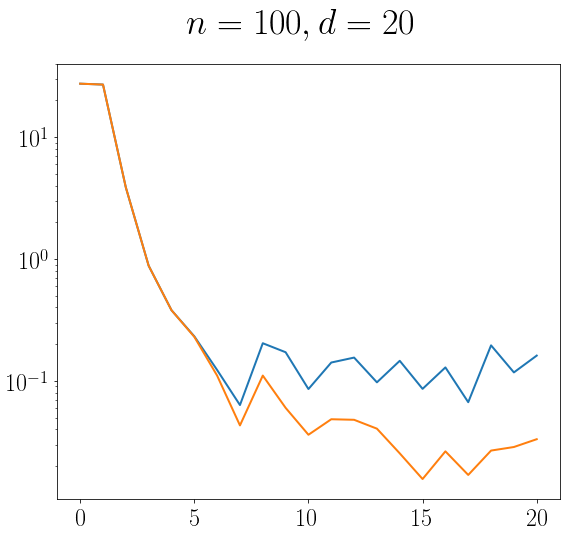

In [111]:
n, d = 100, 20
[x_const, x_adapt], [f_vals_const, f_vals_adapt], [x_err_const, x_err_adapt] = const_vs_decr_ss_comparison(n, d, max_epoch=20)

In [102]:
def const_vs_decr_ss_comparison(n, d, lambd=None, max_epoch=500, seed=0):
    np.random.seed(seed)

    if lambd is None:
        lambd = 1 / n
        
    A = np.random.normal(size=(n, d))
    y = np.random.normal(size=n)
    # Matrix normalization for ||A[i,:]||_2 = 1
#     A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

    # Analytical solution
    x_star = la.inv(A.T @ A + lambd * n * np.eye(d)) @ A.T @ y

    # Problem constants
    mu = min(np.linalg.eigvals(A.T @ A)) / n + lambd
    L = la.norm(A, axis=1, ord=2)**2 + lambd

    M = [np.outer(A[i], A[i]) + lambd * np.eye(d) for i in range(n)]

    sigma_2 = sum([la.norm(grad_f_i(A, i, y, lambd, x_star))**2 for i in range(n)]) / n
    L_curly = int(max([max(abs(la.eigvals(M[i]))) for i in range(len(M))]))

    step_size = select_step_size(L_curly, mu, sigma_2)
#     step_size = 1 / (2 * L_curly)
    print("Step size:", step_size)
    
    k_switch = int(4 * np.ceil(L_curly / mu) / n)
    nbrhd_region_size = calculate_neighborhood_region(step_size, sigma_2, mu)
    print("Neighborhood region size:", nbrhd_region_size)
    
    x_0 = np.random.normal(size=len(x_star))

    # Constant step-size
    x_const, f_vals_const, x_err_const = sgd(A, y, x_0, x_star, lambd, step_size=step_size, max_epoch=max_epoch, epsilon=1e-5)

    # Decreasing step-size
    x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu, max_epoch=max_epoch, epsilon=1e-5)

    
    """PLOTTING"""
    fig = plt.figure(figsize=(9, 8))
    st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

#     plt.subplot(1, 2, 1)

    plt.semilogy(x_err_const, label='Constant step size')
    plt.semilogy(x_err_adapt, label='Decreasing step size')
#     plt.semilogy(x_err_const / la.norm(x_0 - x_star)**2, label='Constant step size')
#     plt.semilogy(x_err_adapt / la.norm(x_0 - x_star)**2, label='Decreasing step size')
#     plt.axvline(k_switch, color='r', label="Regime switch")
    plt.axhline(nbrhd_region_size, color='r', linestyle='--', label="Neighborhood region size")
#     plt.fill_between()
#     plt.axvline(k_switch, color='r')#, label=r"$4 \lceil \mathcal{K} \rlceil$")
#     trans = transforms.blended_transform_factory(plt.get_yticklabels()[0].get_transform(), plt.transData)
#     plt.text(k_switch, 0, "{:.0f}".format(k_switch), color="red", transform=trans)#, ha="right", va="center")
    plt.xlabel("Epoch number: $k$")
    plt.ylabel("Error: "r"$\|x_k - x^*\|^2$")
    plt.grid()
    plt.legend(loc='best', shadow=True)

#     plt.subplot(1, 2, 2)

#     plt.semilogy(f_vals_const - f_ridge(A, y, x_star, lambd), label='Constant step size')
#     plt.semilogy(f_vals_adapt - f_ridge(A, y, x_star, lambd), label='Decreasing step size')
#     plt.axvline(k_switch, color='r', label="Regime switch")
#     plt.xlabel("Epoch number: $k$")
#     plt.ylabel(r"$f(x_k) - f(x^*)$")
#     plt.legend(loc='best', shadow=True)

    st.set_y(1.05)
    fig.subplots_adjust(top=0.95)
    plt.tight_layout()
    plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
    plt.show()
    
    return [x_const, x_adapt], [f_vals_const, f_vals_adapt], [x_err_const, x_err_adapt]

  1%|          | 2272/200000 [00:00<00:08, 22719.26it/s]

Step size: 0.0037081108855504543
Neighborhood region size: 0.09032106716189629


  1%|          | 1910/200000 [00:00<00:10, 19095.19it/s]

Number of epochs: 200
Error: 0.013020865685180957



100%|██████████| 200000/200000 [00:07<00:00, 26781.72it/s]


Number of epochs: 200
Error: 6.67597736012169e-05



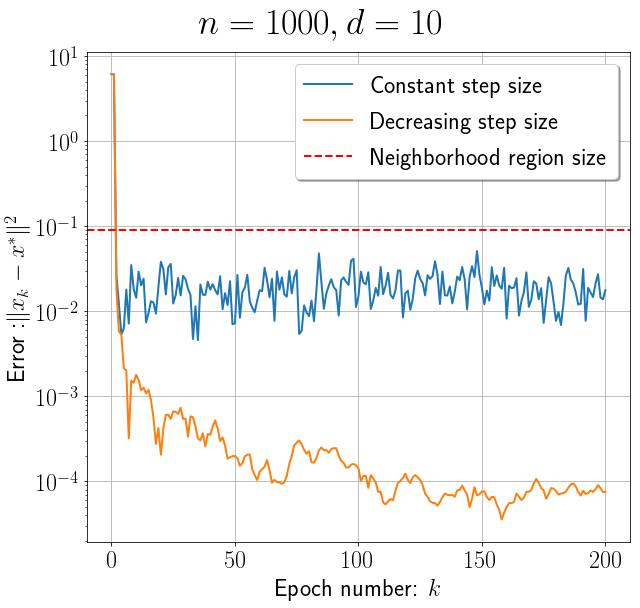

In [103]:
n, d = 1000, 10
[x_const, x_adapt], [f_vals_const, f_vals_adapt], [x_err_const, x_err_adapt] = const_vs_decr_ss_comparison(n, d, max_epoch=200)

In [165]:
n_1, d_1 = 500, 200
max_epoch_1 = 40
lambd = None
seed = 0

np.random.seed(seed)

if lambd is None:
    lambd = 1 / n_1

A = np.random.normal(size=(n_1, d_1))
y = np.random.normal(size=n_1)
# Matrix normalization for ||A[i,:]||_2 = 1
#     A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

# Analytical solution
x_star = la.inv(A.T @ A + lambd * n_1 * np.eye(d_1)) @ A.T @ y

# Problem constants
mu = min(np.linalg.eigvals(A.T @ A)) / n_1 + lambd
L = la.norm(A, axis=1, ord=2)**2 + lambd

M = [np.outer(A[i], A[i]) + lambd * np.eye(d_1) for i in range(n_1)]

sigma_2 = sum([la.norm(grad_f_i(A, i, y, lambd, x_star))**2 for i in range(n_1)]) / n_1
L_curly = int(max([max(abs(la.eigvals(M[i]))) for i in range(len(M))]))

k_switch = int(4 * np.ceil(L_curly / mu) / n_1)

#     step_size = select_step_size(L_curly, mu, sigma_2)
step_size = 1 / (2 * L_curly)
print("Step size:", step_size)

x_0 = np.random.normal(size=len(x_star))

# Constant step-size
x_const_1, f_vals_const_1, x_err_const_1 = sgd(A, y, x_0, x_star, lambd, step_size=step_size, max_epoch=max_epoch_1)

# Decreasing step-size
x_adapt_1, f_vals_adapt_1, x_err_adapt_1 = sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu, max_epoch=max_epoch_1)

 12%|█▏        | 2374/20000 [00:00<00:00, 23719.83it/s]

Step size: 0.001976284584980237


 12%|█▏        | 2327/20000 [00:00<00:00, 23262.76it/s]

Number of epochs: 40
Error: 0.14424010785530195



100%|██████████| 20000/20000 [00:00<00:00, 23188.00it/s]

Number of epochs: 40
Error: 0.05256349845121515



In [191]:
n_2, d_2 = 1000, 400
lambd = None
max_epoch_2 = 200
epsilon =1e-3

np.random.seed(seed)

if lambd is None:
    lambd = 1 / n_2

A = np.random.normal(size=(n_2, d_2))
y = np.random.normal(size=n_2)
# Matrix normalization for ||A[i,:]||_2 = 1
#     A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

# Analytical solution
x_star = la.inv(A.T @ A + lambd * n_2 * np.eye(d_2)) @ A.T @ y

# Problem constants
mu = min(np.linalg.eigvals(A.T @ A)) / n_2 + lambd
L = la.norm(A, axis=1, ord=2)**2 + lambd

M = [np.outer(A[i], A[i]) + lambd * np.eye(d_2) for i in range(n_2)]

sigma_2 = sum([la.norm(grad_f_i(A, i, y, lambd, x_star))**2 for i in range(n_2)]) / n_2
L_curly = int(max([max(abs(la.eigvals(M[i]))) for i in range(len(M))]))

step_size = select_step_size(L_curly, mu, sigma_2)
#     step_size = 1 / (2 * L_curly)
print("Step size:", step_size)

# k_switch = int(4 * np.ceil(L_curly / mu) / n)
nbrhd_region_size = calculate_neighborhood_region(step_size, sigma_2, mu)
print("Neighborhood region size:", nbrhd_region_size)

x_0 = np.random.normal(size=len(x_star))

# Constant step-size
x_const_2, f_vals_const_2, x_err_const_2= sgd(A, y, x_0, x_star, lambd, step_size=step_size, max_epoch=max_epoch, epsilon=epsilon)

# Decreasing step-size
x_adapt_2, f_vals_adapt_2, x_err_adapt_2 = sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu, max_epoch=max_epoch, epsilon=epsilon)

  2%|▏         | 4251/200000 [00:00<00:09, 21238.57it/s]

Step size: 0.001004016064257028
Neighborhood region size: 3.3617341961781166


  1%|          | 1517/200000 [00:00<00:13, 15165.13it/s]

Number of epochs: 200
Error: 0.14787959935413358



100%|██████████| 200000/200000 [00:10<00:00, 18682.19it/s]

Number of epochs: 200
Error: 0.009616499405649119



In [192]:
k_switch = int(4 * np.ceil(L_curly / mu) / n_2)

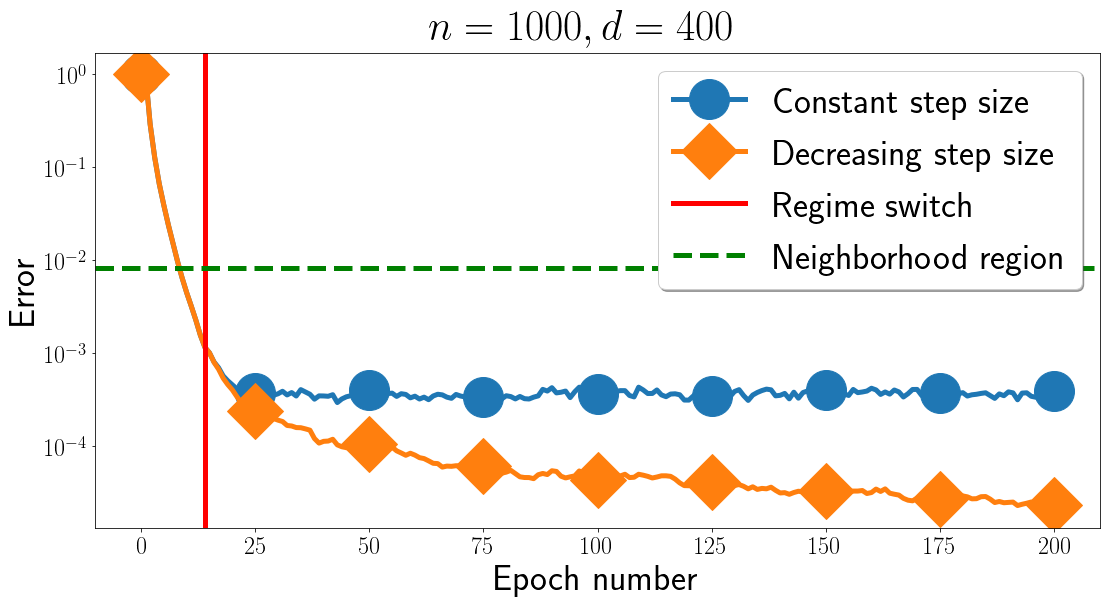

In [247]:
"""PLOTTING"""
fig = plt.figure(figsize=(18, 8))
# plt.title(r"$n = {}, d = {}$".format(n_2, d_2), fontsize=42)
st = fig.suptitle(r"$n = {}, d = {}$".format(n_2, d_2), fontsize=42)

# plt.subplot(1, 2, 1)

plt.semilogy(x_err_const_2 / la.norm(x_0 - x_star)**2, label='Constant step size', marker='o', markersize=40, markevery=25, linewidth=5)
plt.semilogy(x_err_adapt_2 / la.norm(x_0 - x_star)**2, label='Decreasing step size', marker='D', markersize=40, markevery=25, linewidth=5)
plt.axvline(k_switch, color='r', linewidth=5, label="Regime switch")
plt.axhline(nbrhd_region_size / la.norm(x_0 - x_star)**2, 
            color='g', linestyle='--', linewidth=5, label="Neighborhood region") # label=r"$\frac{2 \gamma \sigma^2}{\mu}$"
#     plt.axvline(k_switch, color='r')#, label=r"$4 \lceil \mathcal{K} \rlceil$")
#     trans = transforms.blended_transform_factory(plt.get_yticklabels()[0].get_transform(), plt.transData)
#     plt.text(k_switch, 0, "{:.0f}".format(k_switch), color="red", transform=trans)#, ha="right", va="center")
plt.xlabel("Epoch number")
plt.ylabel("Error") #  r"$\|x_k - x^*\|^2$

# plt.xlim((0, 150))
# plt.grid()
plt.minorticks_off()
# plt.title(r"$n = {}, d = {}$".format(n_1, d_1), y=1.01, fontsize=24)#, fontsize=36)
plt.legend(loc='best', shadow=True)

# plt.subplot(1, 2, 2)

# plt.semilogy(x_err_const_2, label='Constant step size')
# plt.semilogy(x_err_adapt_2, label='Decreasing step size')
# #     plt.semilogy(x_err_const / la.norm(x_0 - x_star)**2, label='Constant step size')
# #     plt.semilogy(x_err_adapt / la.norm(x_0 - x_star)**2, label='Decreasing step size')
# #     plt.axvline(k_switch, color='r', label="Regime switch")
# plt.axhline(nbrhd_region_size, color='r', linestyle='--', label="Neighborhood region") # label=r"$\frac{2 \gamma \sigma^2}{\mu}$"
# #     plt.fill_between()
# #     plt.axvline(k_switch, color='r')#, label=r"$4 \lceil \mathcal{K} \rlceil$")
# #     trans = transforms.blended_transform_factory(plt.get_yticklabels()[0].get_transform(), plt.transData)
# #     plt.text(k_switch, 0, "{:.0f}".format(k_switch), color="red", transform=trans)#, ha="right", va="center")
# plt.xlabel("Epoch number: $k$")
# plt.ylabel("Error: "r"$\|x_k - x^*\|^2$")
# plt.xlim((0, max_epoch_2))
# plt.title(r"$n = {}, d = {}$".format(n_2, d_2), y=1.01, fontsize=24)#, fontsize=36)
# plt.grid()
# plt.minorticks_off()
# plt.legend(loc='best', shadow=True)

st.set_y(1.03)
fig.subplots_adjust(top=0.95)
# plt.tight_layout(w_pad=2)
plt.savefig('constant_vs_decreasing_ss.pdf', bbox_inches='tight')
plt.show()

In [37]:
def const_vs_decr_ss_comparison_(n, d, lambd=None, max_epoch=500, seed=0):
    np.random.seed(seed)

    if lambd is None:
        lambd = 1 / n
        
    A = np.random.normal(size=(n, d))
    y = np.random.normal(size=n)
    # Matrix normalization for ||A[i,:]||_2 = 1
    # A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

    # Analytical solution
    x_star = la.inv(A.T @ A + lambd * n * np.eye(d)) @ A.T @ y

    # Problem constants
    mu = min(np.linalg.eigvals(A.T @ A)) / n + lambd
    L = la.norm(A, axis=1, ord=2)**2 + lambd

    M = [np.outer(A[i], A[i]) + lambd * np.eye(d) for i in range(n)]

    sigma_2 = sum([la.norm(grad_f_i(A, i, y, lambd, x_star))**2 for i in range(n)]) / n
    L_curly = int(max([max(la.eigvals(M[i])) for i in range(len(M))]))
    
    k_switch = int(4 * np.ceil(L_curly / mu) / n)

#     step_size = select_step_size(L_curly, mu, sigma_2)
    step_size = 1 / (2 * L_curly)
    print("Step size:", step_size)

    x_0 = np.random.normal(size=len(x_star))

    # Constant step-size
    x_const, f_vals_const, x_err_const = sgd(A, y, x_0, x_star, lambd, step_size=step_size, max_epoch=max_epoch)

    # Decreasing step-size
    x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu, max_epoch=max_epoch)

    
    """PLOTTING"""
    fig = plt.figure(figsize=(18, 8))
    st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

    plt.subplot(1, 2, 1)

    plt.semilogy(x_err_const, label='Constant step size')
    plt.semilogy(x_err_adapt, label='Decreasing step size')
    plt.axvline(k_switch, color='r', label="Regime switch")
#     plt.axvline(k_switch, color='r')#, label=r"$4 \lceil \mathcal{K} \rlceil$")
#     trans = transforms.blended_transform_factory(plt.get_yticklabels()[0].get_transform(), plt.transData)
#     plt.text(k_switch, 0, "{:.0f}".format(k_switch), color="red", transform=trans)#, ha="right", va="center")
    plt.xlabel("Epoch number: $k$")
    plt.ylabel(r"$\|x_k - x^*\|^2$")
    plt.legend(loc='best', shadow=True)

    plt.subplot(1, 2, 2)

    plt.semilogy(f_vals_const - f_ridge(A, y, x_star, lambd), label='Constant step size')
    plt.semilogy(f_vals_adapt - f_ridge(A, y, x_star, lambd), label='Decreasing step size')
    plt.axvline(k_switch, color='r', label="Regime switch")
    plt.xlabel("Epoch number: $k$")
    plt.ylabel(r"$f(x_k) - f(x^*)$")
    plt.legend(loc='best', shadow=True)

    st.set_y(1.05)
    fig.subplots_adjust(top=0.95)
    plt.tight_layout()
    plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
    plt.show()
    
    return [x_const, x_adapt], [f_vals_const, f_vals_adapt], [x_err_const, x_err_adapt]

/Users/Shulgin_Egor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
 53%|█████▎    | 5321/10000 [00:00<00:00, 26913.74it/s]

45
Step size: 0.011111111111111112


 26%|██▌       | 2568/10000 [00:00<00:00, 25678.43it/s]

Number of epochs: 100
Error: 0.21870201485371749



100%|██████████| 10000/10000 [00:00<00:00, 22929.74it/s]


Number of epochs: 100
Error: 0.011865610542149883



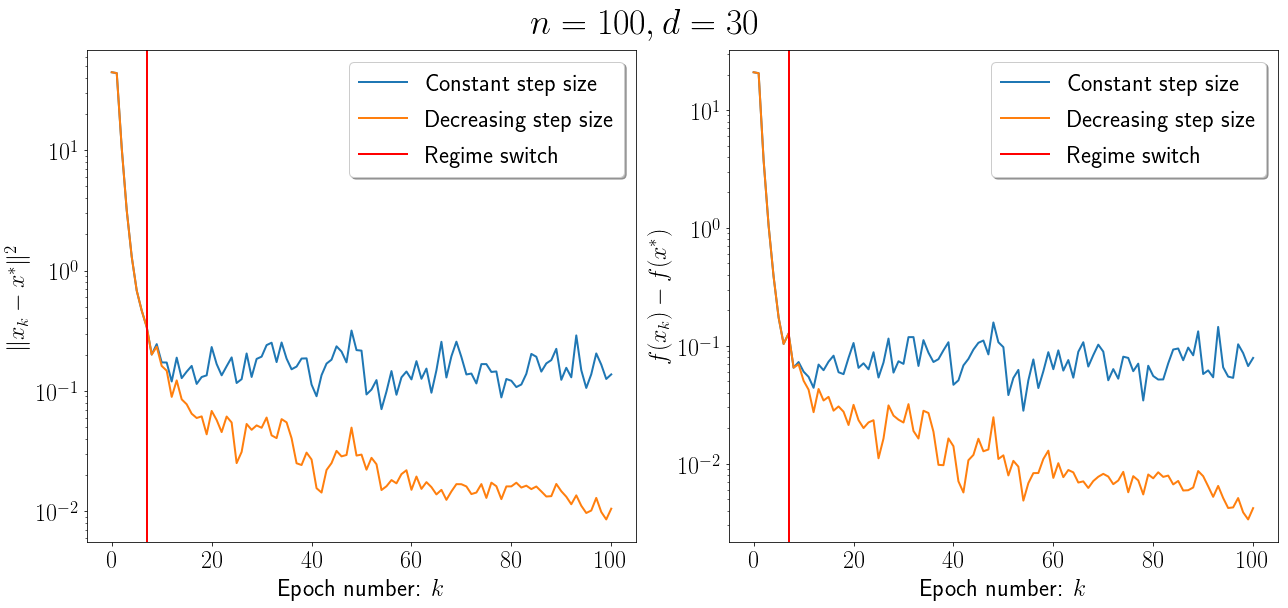

In [38]:
n, d = 100, 30
[x_const, x_adapt], [f_vals_const, f_vals_adapt], [x_err_const, x_err_adapt] = const_vs_decr_ss_comparison_(n, d, max_epoch=100)

# Synthetic data generation

Random matrix $A\in \mathbb{R}^{n \times d}$, $y \in \mathbb{R}^{n}  \sim \mathcal{N}(0, 1)$  
$\lambda = \frac{1}{n}$

#### 1) $n = 50, d = 5$

In [10]:
n = 50
d = 5

np.random.seed(0)

A = np.random.normal(size=(n, d))
y = np.random.normal(size=n)

lambd = 1 / n

# Matrix normalization for ||A[i,:]||_2 = 1
# A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

Constants:
$$
L_i = \| \mathbf{A}(i,:) \|_2^2 + \lambda \ \ \forall i \\
\mu = \frac{1}{n} \lambda_{\text{min}}(\mathbf{A}^T \mathbf{A}) + \lambda
$$

In [11]:
mu = min(np.linalg.eigvals(A.T @ A)) / n + lambd
L = la.norm(A, axis=1, ord=2)**2 + lambd

In [12]:
# Analytical solution

x_star = la.inv(A.T @ A + lambd * n * np.eye(d)) @ A.T @ y
# Linear system alternative: la.solve(A.T @ A + lambd * n * np.eye(shape=d), A.T @ y)

Step size defined by hands

In [13]:
%%time 
x_opt, f_vals, x_err = sgd(A, y, x_0=np.zeros(d), x_star=x_star, 
                           step_size=1e-4, lambd=lambd, max_epoch=400)

Number of epochs: 400
Error: 0.0011251008429187174

CPU times: user 396 ms, sys: 5.91 ms, total: 402 ms
Wall time: 419 ms


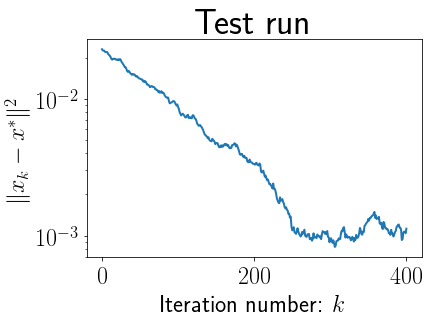

In [14]:
plt.semilogy(x_err)
plt.xlabel("Iteration number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.title("Test run")
plt.show()

# Calculation of parameters according to our paper

For sampling with such property $\mathbb{E} |S| = 1$. This is for uniform sampling:
$$
\sigma^2 = \frac{1}{n^2} \sum\limits_{i \in [n]} \frac{1}{p_i} \| h_i \|^2 
= | p_i = 1 / n |
= \frac{1}{n} \sum\limits_{i=1}^n \| \nabla f_i (x^*) \|^2 \\
\mathcal{L} := \mathcal{L}^i_{\text{max}} = \frac{1}{n} \max\limits_{i \in [n]} \frac{\lambda_{\text{max}}(M_i)}{p_i}
= | p_i = 1 / n |
= \max\limits_{i=\overline{1,n}} \lambda_{\text{max}}(M_i) \\
\text{Step size:} \ \gamma = \min \left\{ \frac{1}{2 \mathcal{L}}, \frac{\epsilon \mu}{4 \sigma^2} \right\}
$$

In [15]:
M = [np.outer(A[i], A[i]) + lambd * np.eye(d) for i in range(n)]

In [16]:
sigma_2 = sum([la.norm(grad_f_i(A, i, y, lambd, x_star))**2 for i in range(n)]) / n
L_curly = max([max(la.eigvals(M[i])) for i in range(len(M))])

In [50]:
# Illustration of Th. 6.2 corollary

epsilon = 1e-6
print("Epsilon =", epsilon)
ss_1 = select_step_size(L_curly, mu, sigma_2, epsilon)
# ss_1 = 1 / (2 * L_curly)
print("Our step size:", ss_1)

# Expected minimum number of epochs according to Th. 3.3 

x_1 = np.random.normal(size=len(x_star))

print("Expected minimum number of epochs:", 
      int(max(L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_1)**2 / epsilon) / A.shape[0]))

Epsilon = 1e-06
Our step size: 2.256018850631476e-05
Expected minimum number of epochs: 17936804


In [51]:
%%time 
x_opt_1, f_vals_1, x_err_1 = sgd(A, y, x_1, x_star, lambd, epsilon=epsilon,
                                 step_size=ss_1, max_epoch=100000)

Number of epochs: 30841
Error: 7.350467336706802e-07

CPU times: user 36.1 s, sys: 379 ms, total: 36.5 s
Wall time: 38.9 s


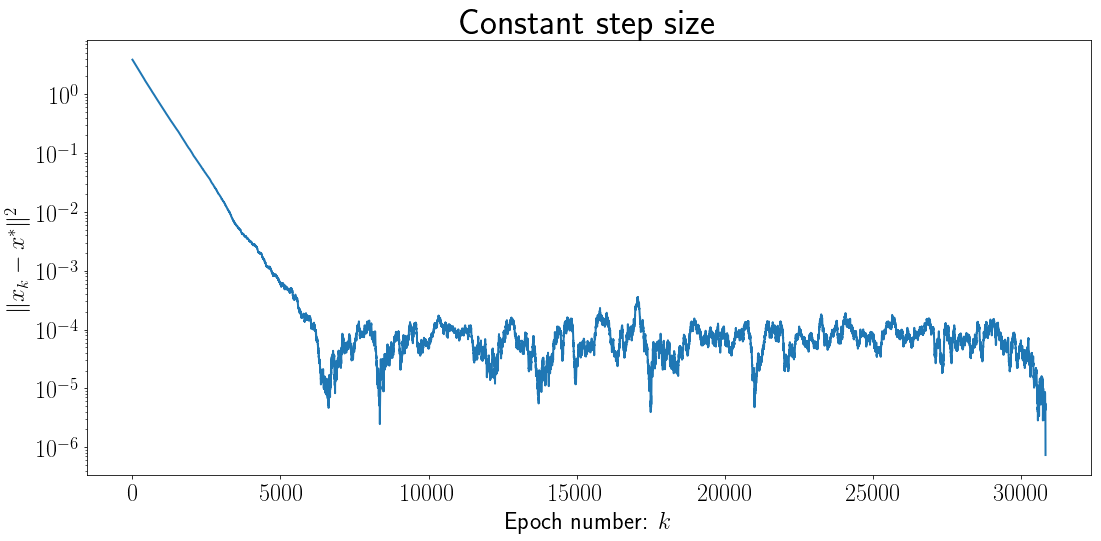

In [52]:
plt.figure(figsize=(18, 8))
plt.rc('text', usetex=True)

plt.semilogy(x_err_1)

plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.title("Constant step size")
plt.show()

In [45]:
max_epoch = 2000

In [39]:
%%time 
# Constant step size
x_opt_1, f_vals_1, x_err_1 = sgd(A, y, x_1, x_star, lambd,
                                 step_size=ss_1, max_epoch=max_epoch)

Number of epochs: 2000
Error: 0.03870584183041065

CPU times: user 1.8 s, sys: 7.88 ms, total: 1.81 s
Wall time: 1.81 s


In [38]:
%%time 
# Decreasing step size
x_opt_adapt_1, f_vals_adapt_1, x_err_adapt_1 = sgd_adaptive(A, y, x_1, x_star, lambd, L_curly, mu, max_epoch=max_epoch)

Number of epochs: 2000
Error: 9.481449266299643e-05

CPU times: user 2.45 s, sys: 17.9 ms, total: 2.47 s
Wall time: 2.5 s


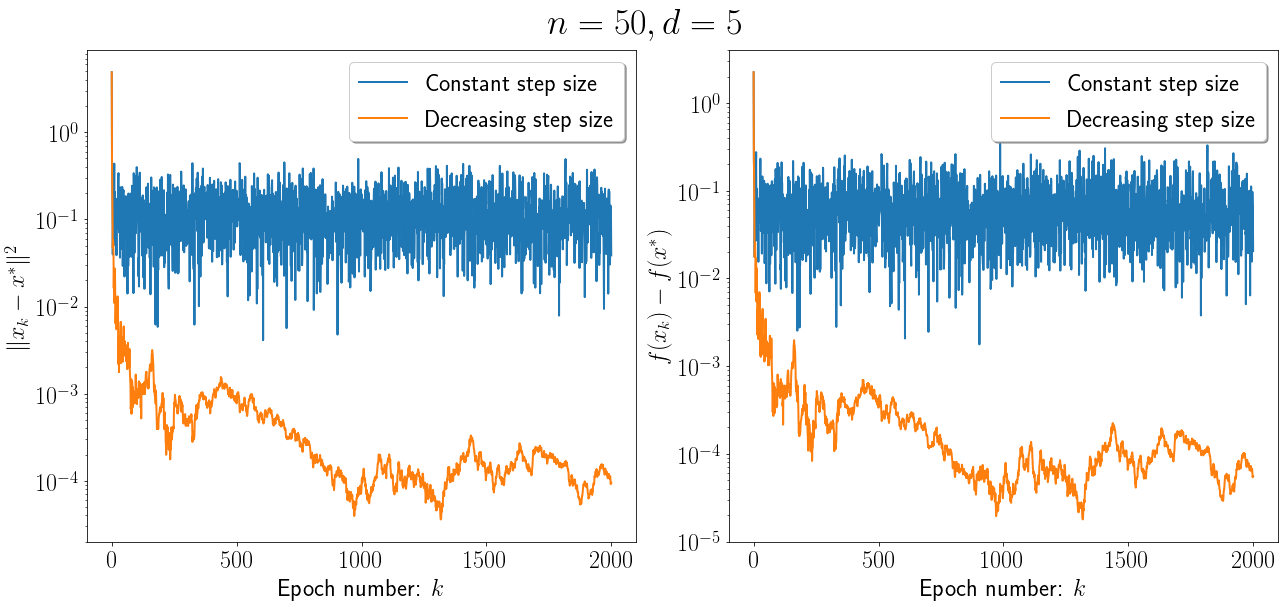

In [40]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err_1, label='Constant step size')
plt.semilogy(x_err_adapt_1, label='Decreasing step size')
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

plt.subplot(1, 2, 2)

plt.semilogy(f_vals_1 - f_ridge(A, y, x_star, lambd), label='Constant step size')
plt.semilogy(f_vals_adapt_1 - f_ridge(A, y, x_star, lambd), label='Decreasing step size')
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)

# plt.title("l")
# plt.suptitle("l")
plt.tight_layout()
# plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

In [25]:
# Write results to file

with open("1_const.txt", "w") as f:
    for err in x_err_1:
        f.write(str(err) + "\n")

with open("1_adapt.txt", "w") as f:
    for err in x_err_adapt_1:
        f.write(str(err) + "\n")
        
        
# numpy alternative
# np.save("test.txt", x_err_1)
# np.load("test.npy")

In [26]:
# Read results

# x_err_1 = []
# x_err_adapt_1 = []

# with open("1_const.txt", "r") as f:
#     for line in f:
#         x_err_1.append(float(line.strip()))

# with open("1_adapt.txt", "r") as f:
#     for line in f:
#         x_err_adapt_1.append(float(line.strip()))

#### 1.1) $n = 100, d = 20$

In [42]:
# N=100
# D =10, 20, 50
n = 100
d = 20

np.random.seed(0)

A = np.random.normal(size=(n, d))
y = np.random.normal(size=n)

lambd = 1 / n

# Matrix normalization for ||A[i,:]||_2 = 1
# A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)


# Analytical solution
x_star = la.inv(A.T @ A + lambd * n * np.eye(d)) @ A.T @ y
# Linear system alternative: la.solve(A.T @ A + lambd * n * np.eye(shape=d), A.T @ y)

# Problem constants
mu = min(np.linalg.eigvals(A.T @ A)) / n + lambd
L = la.norm(A, axis=1, ord=2)**2 + lambd

# A[0, :][:, np.newaxis] to make vectors from arrays
M = [np.outer(A[i], A[i]) + lambd * np.eye(d) for i in range(n)]

sigma_2 = sum([la.norm(grad_f_i(A, i, lambd, x_star))**2 for i in range(n)]) / n
# I had to cast the variable to int type because function returned complex number
L_curly = int(max([max(la.eigvals(M[i])) for i in range(len(M))]))

step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
print("Our step size:", step_size)

# Expected minimum number of iterations according to Th. 3.3
x_0 = np.random.normal(size=len(x_star))

print("Expected minimum number of epochs:", 
      int(max(L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon) / n))
print()

max_epoch = 250

# Constant step-size
x_opt_const, f_vals_const, x_err_const = sgd(A, y, x_0, x_star, lambd, step_size=step_size, max_epoch=max_epoch)

# Decreasing step-size
x_opt_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu, max_epoch=max_epoch)

/Users/Shulgin_Egor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


Our step size: 0.014705882352941176
Expected minimum number of epochs: 143365
Number of epochs: 250
Error: 0.22447111592400484

Number of epochs: 250
Error: 0.0030542307250698286



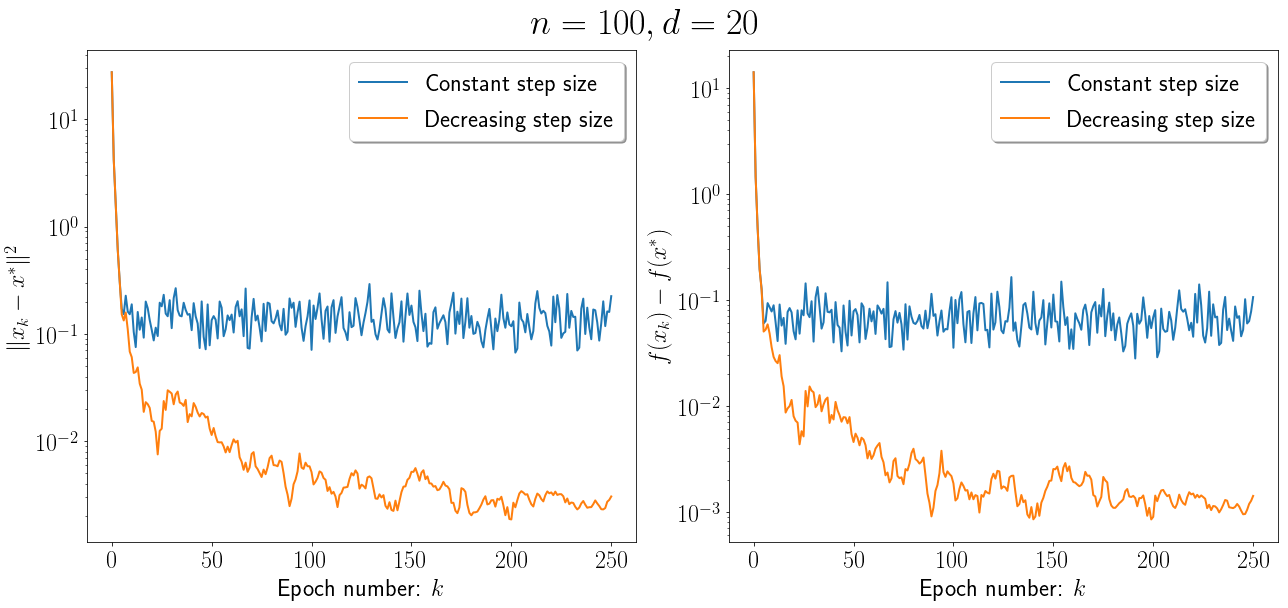

In [43]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err_const, label='Constant step size')
plt.semilogy(x_err_adapt, label='Decreasing step size')
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')


plt.subplot(1, 2, 2)

plt.semilogy(f_vals_const - f_ridge(A, y, x_star, lambd), label='Constant step size')
plt.semilogy(f_vals_adapt - f_ridge(A, y, x_star, lambd), label='Decreasing step size')
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)

plt.tight_layout()
plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

In [45]:
print("Neighborhood size according to Th 3.3:", 2 * step_size * sigma_2 / mu)

Neighborhood size according to Th 3.3: 0.2853039321669603


In [46]:
# Write results to file

with open("const_{}-{}.txt".format(n, d), "w") as f:
    for err in x_err_const:
        f.write(str(err) + "\n")

with open("adapt_{}-{}.txt".format(n, d), "w") as f:
    for err in x_err_adapt:
        f.write(str(err) + "\n")
        
        
# numpy alternative
# np.save("test.txt", x_err_1)
# np.load("test.npy")

In [62]:
# Read results

# x_err_1 = []
# x_err_adapt_1 = []

# with open("1_const.txt", "r") as f:
#     for line in f:
#         x_err_1.append(float(line.strip()))

# with open("1_adapt.txt", "r") as f:
#     for line in f:
#         x_err_adapt_1.append(float(line.strip()))

#### 2) $n = 100, d = 10$

In [82]:
n = 100
d = 10

np.random.seed(0)

A = np.random.normal(size=(n, d))
y = np.random.normal(size=n)

lambd = 1 / n

# Matrix normalization for ||A[i,:]||_2 = 1
# A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

In [83]:
# Analytical solution

x_star = la.inv(A.T @ A + lambd * n * np.eye(d)) @ A.T @ y
# Linear system alternative: la.solve(A.T @ A + lambd * n * np.eye(shape=d), A.T @ y)

In [84]:
# Problem constants

mu = min(np.linalg.eigvals(A.T @ A)) / n + lambd
L = la.norm(A, axis=1, ord=2)**2 + lambd

In [85]:
M = [np.outer(A[i], A[i]) + lambd * np.eye(d) for i in range(n)]

In [86]:
sigma_2 = sum([la.norm(grad_f_i(A, i, lambd, x_star))**2 for i in range(n)]) / n
L_curly = int(max([max(la.eigvals(M[i])) for i in range(len(M))]))

/Users/Shulgin_Egor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [87]:
ss_2 = select_step_size(L_curly, mu, sigma_2, epsilon)
print("Our step size:", ss_2)

Our step size: 0.020833333333333332


In [88]:
# Expected minimum number of iterations according to Th. 3.3

x_2 = np.random.normal(size=len(x_star))

print("Expected minimum number of epochs:", 
      int(max(L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_2)**2 / epsilon) / A.shape[0]))

Expected minimum number of epochs: 21322


In [89]:
max_epoch_2 = 250

In [90]:
%%time 
# Constant step-size
x_opt_2, f_vals_2, x_err_2 = sgd(A, y, x_2, x_star, lambd,
                                 step_size=ss_2, max_epoch=max_epoch_2)

Number of epochs: 250
Error: 0.07656232687262947

CPU times: user 533 ms, sys: 8.01 ms, total: 541 ms
Wall time: 578 ms


In [91]:
%%time 
# Decreasing step-size
x_opt_adapt_2, f_vals_adapt_2, x_err_adapt_2 = sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu, max_epoch=max_epoch_2)

Number of epochs: 250
Error: 0.00044879583862448473

CPU times: user 611 ms, sys: 7.37 ms, total: 618 ms
Wall time: 646 ms


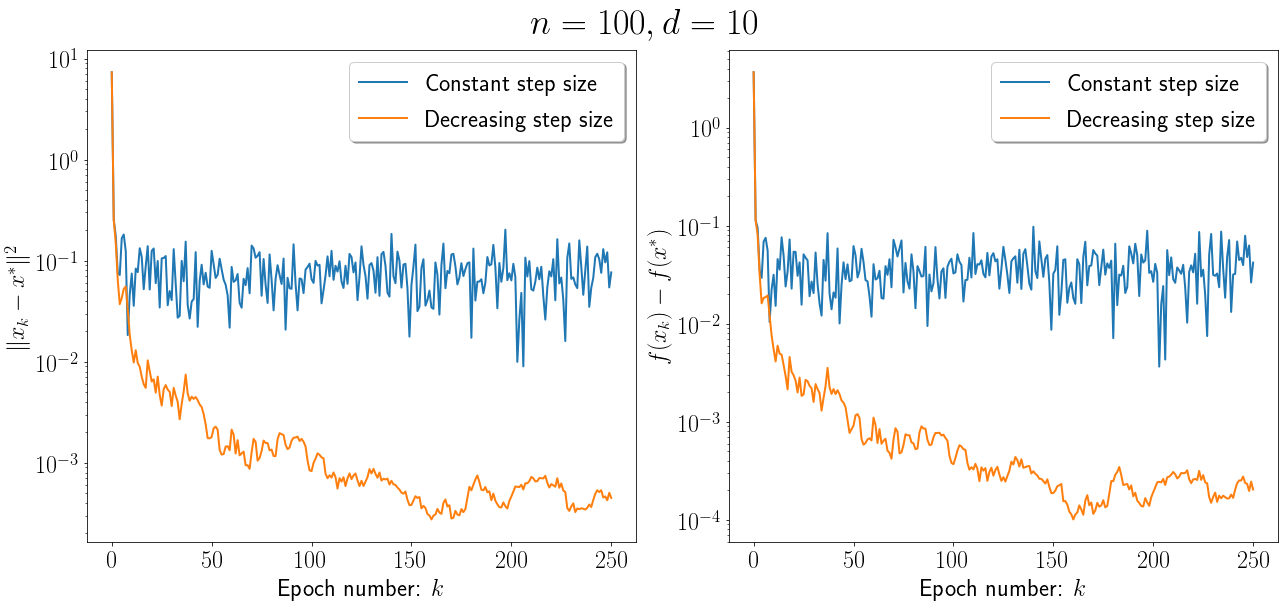

In [92]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err_2, label='Constant step size')
plt.semilogy(x_err_adapt_2, label='Decreasing step size')
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')


plt.subplot(1, 2, 2)

plt.semilogy(f_vals_2 - f_ridge(A, y, x_star, lambd), label='Constant step size')
plt.semilogy(f_vals_adapt_2 - f_ridge(A, y, x_star, lambd), label='Decreasing step size')
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)

plt.tight_layout()
plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

In [93]:
# Write results to file

with open("2_const.txt", "w") as f:
    for err in x_err_2:
        f.write(str(err) + "\n")

with open("2_adapt.txt", "w") as f:
    for err in x_err_adapt_2:
        f.write(str(err) + "\n")
        
        
# numpy alternative
# np.save("test.txt", x_err_1)
# np.load("test.npy")

In [94]:
# Read results

# x_err_1 = []
# x_err_adapt_1 = []

# with open("1_const.txt", "r") as f:
#     for line in f:
#         x_err_1.append(float(line.strip()))

# with open("1_adapt.txt", "r") as f:
#     for line in f:
#         x_err_adapt_1.append(float(line.strip()))

#### 3) $n = 500, d = 50$

In [95]:
n = 500
d = 50

np.random.seed(0)

A = np.random.normal(size=(n, d))
y = np.random.normal(size=n)

lambd = 1 / n

# Matrix normalization for ||A[i,:]||_2 = 1
# A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

In [96]:
# Analytical solution
x_star = la.inv(A.T @ A + lambd * n * np.eye(d)) @ A.T @ y
# Linear system alternative: la.solve(A.T @ A + lambd * n * np.eye(shape=d), A.T @ y)

In [97]:
# Problem constants
mu = min(np.linalg.eigvals(A.T @ A)) / n + lambd
L = la.norm(A, axis=1, ord=2)**2 + lambd

M = [np.outer(A[i], A[i]) + lambd * np.eye(d) for i in range(n)]

In [98]:
sigma_2 = sum([la.norm(grad_f_i(A, i, lambd, x_star))**2 for i in range(n)]) / n
L_curly = int(max([max(la.eigvals(M[i])) for i in range(len(M))]))

/Users/Shulgin_Egor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [99]:
ss_3 = select_step_size(L_curly, mu, sigma_2, epsilon)
print("Our step size:", ss_3)

Our step size: 0.006024096385542169


In [100]:
# Expected minimum number of iterations according to Th. 3.3

x_3 = np.random.normal(size=len(x_star))

print("Expected minimum number of epochs:", 
      int(max(L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_3)**2 / epsilon) / A.shape[0]))

Expected minimum number of epochs: 19032


In [101]:
max_epoch_3 = 500

In [102]:
%%time 
# Constant step-size
x_opt_3, f_vals_3, x_err_3 = sgd(A, y, x_3, x_star, lambd,
                                 step_size=ss_3, max_epoch=max_epoch_3)

Number of epochs: 500
Error: 0.167997573835251

CPU times: user 11.4 s, sys: 207 ms, total: 11.6 s
Wall time: 6.36 s


In [103]:
%%time 
# Decreasing step-size
x_opt_adapt_3, f_vals_adapt_3, x_err_adapt_3 = sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu, max_epoch=max_epoch_3)

Number of epochs: 500
Error: 0.00042590147860072

CPU times: user 13.1 s, sys: 231 ms, total: 13.3 s
Wall time: 7.67 s


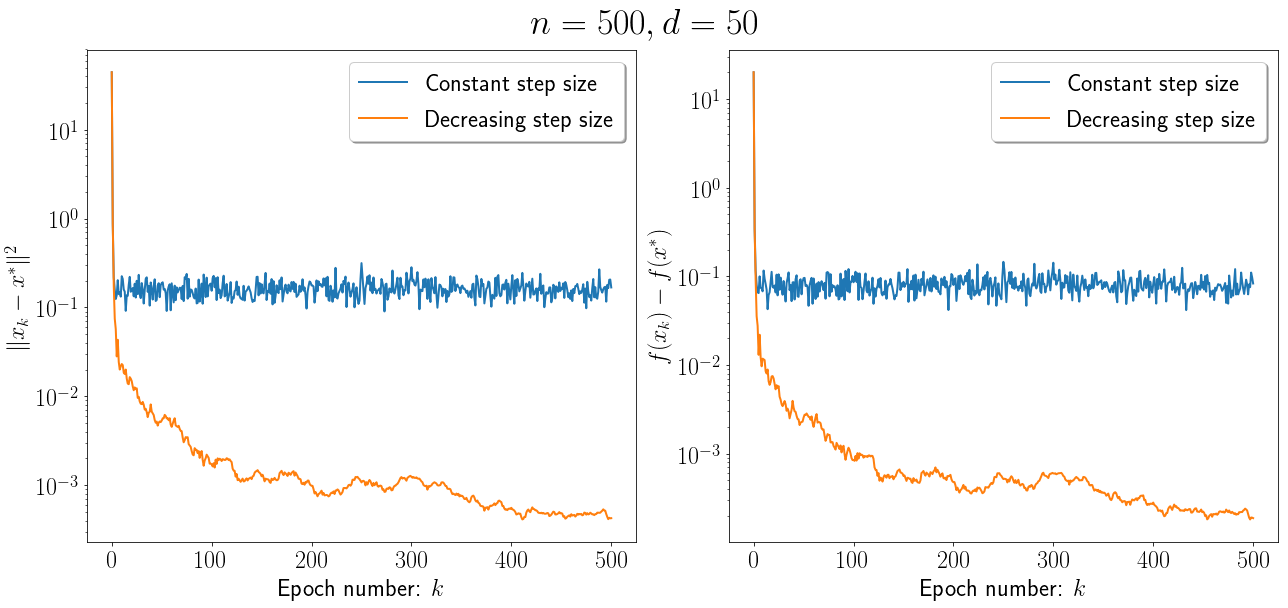

In [104]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err_3, label='Constant step size')
plt.semilogy(x_err_adapt_3, label='Decreasing step size')
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')


plt.subplot(1, 2, 2)

plt.semilogy(f_vals_3 - f_ridge(A, y, x_star, lambd), label='Constant step size')
plt.semilogy(f_vals_adapt_3 - f_ridge(A, y, x_star, lambd), label='Decreasing step size')
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)

plt.tight_layout()
plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

In [106]:
print("Neighborhood size according to Th 3.3:", 2 * ss_3 * sigma_2 / mu)

Neighborhood size according to Th 3.3: 0.09888054373017832


In [51]:
# Read results

# x_err_1 = []
# x_err_adapt_1 = []

# with open("1_const.txt", "r") as f:
#     for line in f:
#         x_err_1.append(float(line.strip()))

# with open("1_adapt.txt", "r") as f:
#     for line in f:
#         x_err_adapt_1.append(float(line.strip()))

#### 4) $n = 1000, d = 100$

In [107]:
n = 1000
d = 100

np.random.seed(0)

A = np.random.normal(size=(n, d))
y = np.random.normal(size=n)

lambd = 1 / n

# Matrix normalization for ||A[i,:]||_2 = 1
# A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

In [108]:
# Analytical solution
x_star = la.inv(A.T @ A + lambd * n * np.eye(d)) @ A.T @ y
# Linear system alternative: la.solve(A.T @ A + lambd * n * np.eye(shape=d), A.T @ y)

# Problem constants
mu = min(np.linalg.eigvals(A.T @ A)) / n + lambd
L = la.norm(A, axis=1, ord=2)**2 + lambd

# A[0, :][:, np.newaxis] to make vectors from arrays
M = [np.outer(A[i], A[i]) + lambd * np.eye(d) for i in range(n)]

sigma_2 = sum([la.norm(grad_f_i(A, i, lambd, x_star))**2 for i in range(n)]) / n
# I had to cast the variable to int type because function returned complex number
L_curly = int(max([max(la.eigvals(M[i])) for i in range(len(M))]))

/Users/Shulgin_Egor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [109]:
ss_4 = select_step_size(L_curly, mu, sigma_2, epsilon)
print("Our step size:", ss_4)

Our step size: 0.003125


In [110]:
# Expected minimum number of iterations according to Th. 3.3

x_4 = np.random.normal(size=len(x_star))

print("Expected minimum number of epochs:", 
      int(max(L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_4)**2 / epsilon) / n))

Expected minimum number of epochs: 26274


In [111]:
max_epoch_4 = 500

In [112]:
%%time 
# Constant step-size
x_opt_4, f_vals_4, x_err_4 = sgd(A, y, x_4, x_star, lambd,
                                 step_size=ss_4, max_epoch=max_epoch_4)

Number of epochs: 500
Error: 0.15745691163522782

CPU times: user 20.3 s, sys: 288 ms, total: 20.6 s
Wall time: 10.8 s


In [113]:
%%time 
# Decreasing step-size
x_opt_adapt_4, f_vals_adapt_4, x_err_adapt_4 = sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu, max_epoch=max_epoch_4)

Number of epochs: 500
Error: 0.00041972268744317246

CPU times: user 25.1 s, sys: 361 ms, total: 25.5 s
Wall time: 13.4 s


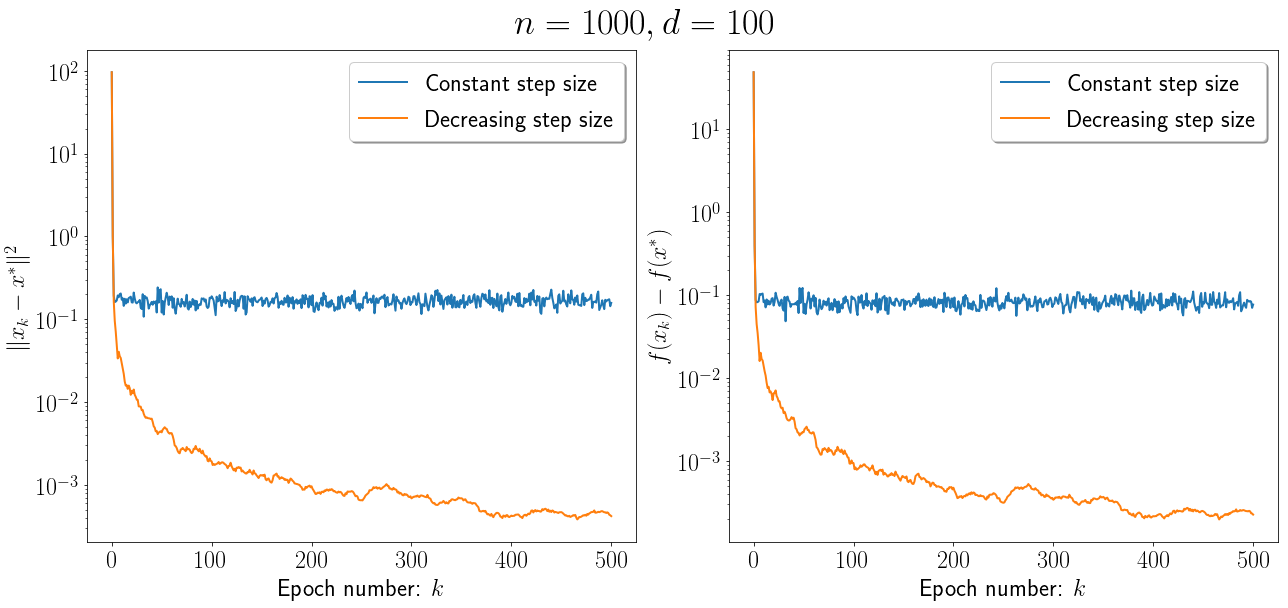

In [114]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err_4, label='Constant step size')
plt.semilogy(x_err_adapt_4, label='Decreasing step size')
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')


plt.subplot(1, 2, 2)

plt.semilogy(f_vals_4 - f_ridge(A, y, x_star, lambd), label='Constant step size')
plt.semilogy(f_vals_adapt_4 - f_ridge(A, y, x_star, lambd), label='Decreasing step size')
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)

plt.tight_layout()
plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

In [115]:
print("Neighborhood size according to Th 3.3:", 2 * ss_3 * sigma_2 / mu)

Neighborhood size according to Th 3.3: 0.26586875334041377


In [60]:
# Write results to file

with open("4_const.txt", "w") as f:
    for err in x_err_4:
        f.write(str(err) + "\n")

with open("4_adapt.txt", "w") as f:
    for err in x_err_adapt_4:
        f.write(str(err) + "\n")
        
        
# numpy alternative
# np.save("test.txt", x_err_1)
# np.load("test.npy")

In [62]:
# Read results

# x_err_1 = []
# x_err_adapt_1 = []

# with open("1_const.txt", "r") as f:
#     for line in f:
#         x_err_1.append(float(line.strip()))

# with open("1_adapt.txt", "r") as f:
#     for line in f:
#         x_err_adapt_1.append(float(line.strip()))

In [54]:
# from collections import defaultdict
# hash_ = defaultdict(dict)
# hash_[100][200] = [[[1, 2, 3], [4, 5, 6]], [[1, 2, 3], [4, 5, 6]], [[1, 2, 3], [4, 5, 6]]]

In [40]:
def plot_const_vs_decr_ss_comparison(n, d, f_star_vals, f_vals_const, f_vals_adapt, x_err_const, x_err_adapt):    
    fig = plt.figure(figsize=(18, 8))
    st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

    plt.subplot(1, 2, 1)
    fig.add_subplot(1,1,1)
    # plt.subplot(4,4,i+1)

    plt.semilogy(x_err_const, label='Constant step size')
    plt.semilogy(x_err_adapt, label='Decreasing step size')
    plt.xlabel("Epoch number: $k$")
    plt.ylabel(r"$\|x_k - x^*\|^2$")
    plt.legend(loc='best', shadow=True)


    plt.subplot(1, 2, 2)

    plt.semilogy(f_vals_const - f_ridge(A, y, x_star, lambd), label='Constant step size')
    plt.semilogy(f_vals_adapt - f_ridge(A, y, x_star, lambd), label='Decreasing step size')
    plt.xlabel("Epoch number: $k$")
    plt.ylabel(r"$f(x_k) - f(x^*)$")
    plt.legend(loc='best', shadow=True)

    st.set_y(1.05)
    fig.subplots_adjust(top=0.95)
    
#     plt.vlines()
    plt.axvline(4 * L_curly / mu)
    plt.tight_layout()
    plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
    plt.show()

In [42]:
# N=100
# D =10, 20, 50
n = 100
d = 20

np.random.seed(0)

A = np.random.normal(size=(n, d))
y = np.random.normal(size=n)

lambd = 1 / n

# Matrix normalization for ||A[i,:]||_2 = 1
# A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)


# Analytical solution
x_star = la.inv(A.T @ A + lambd * n * np.eye(d)) @ A.T @ y
# Linear system alternative: la.solve(A.T @ A + lambd * n * np.eye(shape=d), A.T @ y)

# Problem constants
mu = min(np.linalg.eigvals(A.T @ A)) / n + lambd
L = la.norm(A, axis=1, ord=2)**2 + lambd

# A[0, :][:, np.newaxis] to make vectors from arrays
M = [np.outer(A[i], A[i]) + lambd * np.eye(d) for i in range(n)]

sigma_2 = sum([la.norm(grad_f_i(A, i, x_star))**2 for i in range(n)]) / n
# I had to cast the variable to int type because function returned complex number
L_curly = int(max([max(la.eigvals(M[i])) for i in range(len(M))]))

step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
print("Our step size:", step_size)

# Expected minimum number of iterations according to Th. 3.3
x_0 = np.random.normal(size=len(x_star))

print("Expected minimum number of epochs:", 
      int(max(L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon) / n))
print()

max_epoch = 250

# Constant step-size
x_opt_const, f_vals_const, x_err_const = sgd(A, y, x_0, x_star, lambd, step_size=step_size, max_epoch=max_epoch)

# Decreasing step-size
x_opt_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu, max_epoch=max_epoch)

/Users/Shulgin_Egor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


Our step size: 0.014705882352941176
Expected minimum number of epochs: 143365
Number of epochs: 250
Error: 0.22447111592400484

Number of epochs: 250
Error: 0.0030542307250698286



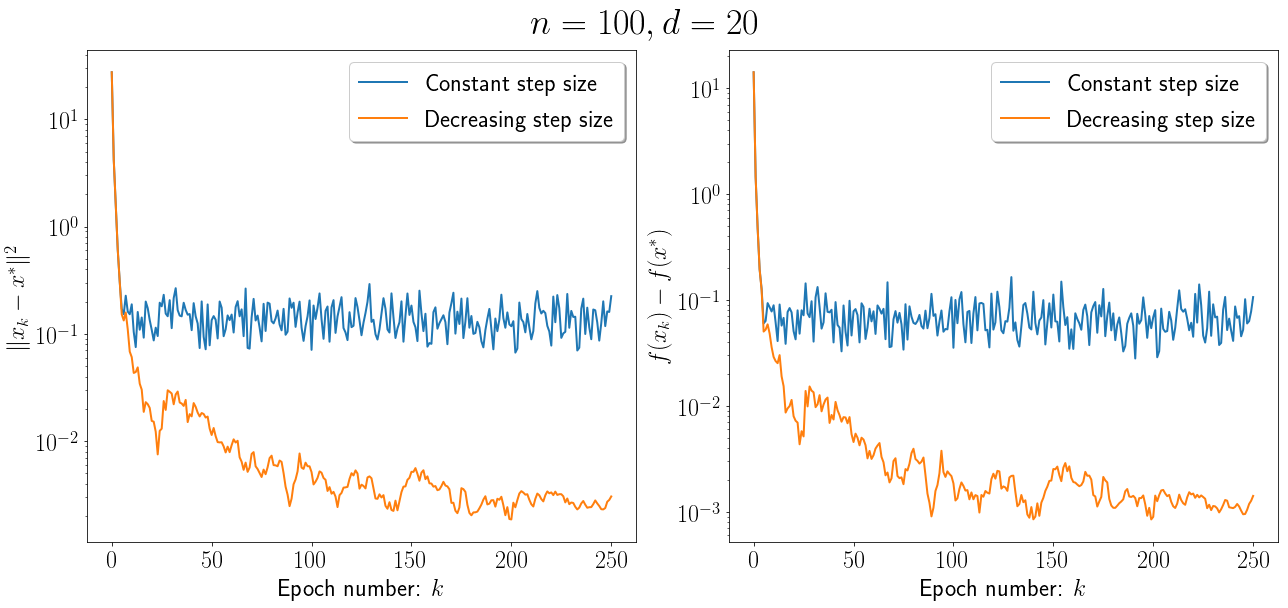

In [43]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err_const, label='Constant step size')
plt.semilogy(x_err_adapt, label='Decreasing step size')
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')


plt.subplot(1, 2, 2)

plt.semilogy(f_vals_const - f_ridge(A, y, x_star, lambd), label='Constant step size')
plt.semilogy(f_vals_adapt - f_ridge(A, y, x_star, lambd), label='Decreasing step size')
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)

plt.tight_layout()
plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

In [45]:
print("Neighborhood size according to Th 3.3:", 2 * step_size * sigma_2 / mu)

Neighborhood size according to Th 3.3: 0.2853039321669603


In [46]:
# Write results to file

with open("const_{}-{}.txt".format(n, d), "w") as f:
    for err in x_err_const:
        f.write(str(err) + "\n")

with open("adapt_{}-{}.txt".format(n, d), "w") as f:
    for err in x_err_adapt:
        f.write(str(err) + "\n")
        
        
# numpy alternative
# np.save("test.txt", x_err_1)
# np.load("test.npy")

In [62]:
# Read results

# x_err_1 = []
# x_err_adapt_1 = []

# with open("1_const.txt", "r") as f:
#     for line in f:
#         x_err_1.append(float(line.strip()))

# with open("1_adapt.txt", "r") as f:
#     for line in f:
#         x_err_adapt_1.append(float(line.strip()))

# Calculation of parameters according to Needell (2016) paper

$\sigma^2$ from our paper.
$$
\text{Step size}: \gamma = \frac{\mu \epsilon}{2 \epsilon \mu \sup L + 2 \sigma^2}
$$

In [101]:
Needell_step_size = mu * epsilon / (2 * epsilon * mu * max(L) + 2 * sigma_2)
print("Needell step size:", Needell_step_size)

Needell stepsize: 1.8031517842081384e-05


In [102]:
print("Expected minimum number of steps:", 
      2 * np.log(2 * la.norm(x_star - x_1)**2 / epsilon) * (max(L) / mu + sigma_2 / (mu**2 * epsilon)))

Expected minimum number of steps: 725501.3033037632


In [103]:
%%time 
x_optimum, f_vals, x_err = sgd(A, y, x_0=np.zeros(d), x_star=x_star, 
                               step_size=Needell_step_size, lambd=lambd, max_epoch=400)

Number of epochs: 400
CPU times: user 818 ms, sys: 11.6 ms, total: 830 ms
Wall time: 887 ms


In [104]:
print("Error:", la.norm(x_optimum - x_star)**2)

Error: 0.03233785835654317


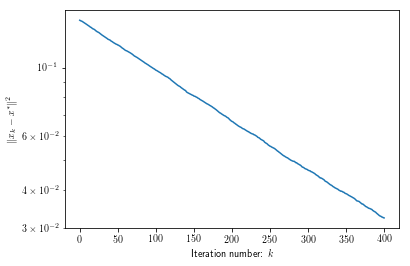

In [105]:
plt.rc('text', usetex=True)
plt.semilogy(x_err)
plt.xlabel("Iteration number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.show()

In [106]:
# Importance sampling from "icml15-sois"

def is_probs_calculation(L):
     return L / sum(L)
#     return [la.norm(grad_f_i(A, i, x_star))**2 for i in range(n)] / sum([la.norm(grad_f_i(A, i, x_star))**2 for i in range(n)])

In [107]:
p = is_probs_calculation(L)

In [108]:
def is_sgd(A, y, x_0, x_star, lambd=1.0, step_size=1e-2, batch_size=1, epsilon=1e-6, max_epoch=100, seed=42):
    np.random.seed(seed)
    
    x = x_0
    
    epoch_n = 0
    iter_num = 0
    
    error = [la.norm(x - x_star)**2]
    f_values = [f_ridge(A, y, x, lambd)]
    
    while epoch_n < max_epoch and error[-1] > epsilon: 
        
        random_ind = np.random.choice(A.shape[0], size=1, p=p, replace=False)
        x = sgd_ridge_step(A, y, x, random_ind, lambd, step_size)
        
        iter_num += 1
        
        if iter_num >= A.shape[0]:
            iter_num = 0
            epoch_n += 1
            
            f_values.append(f_ridge(A, y, x, lambd))
            error.append(la.norm(x - x_star)**2)
    
    print("Number of epochs:", epoch_n)
    
    return x, f_values, error

In [78]:
%%time 
x_optimum, f_vals, x_err = is_sgd(A, y, x_0=np.zeros(d), x_star=x_star, 
                                  step_size=our_step_size, lambd=lambd, max_epoch=400)

Number of epochs: 400
CPU times: user 3.96 s, sys: 24.9 ms, total: 3.98 s
Wall time: 4.03 s


In [79]:
print("Error:", la.norm(x_optimum - x_star)**2)

Error: 0.014462935447080758


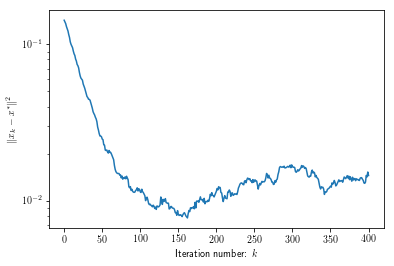

In [80]:
plt.rc('text', usetex=True)
plt.semilogy(x_err)
plt.xlabel("Iteration number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.show()

In [17]:
from sklearn.datasets import load_svmlight_file

def get_data(file_path):
    data = load_svmlight_file(file_path)
    return data[0], data[1]

In [100]:
!wget -t inf https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/mg

--2019-01-22 20:40:25--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/mg
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152350 (149K)
Saving to: ‘mg’

mg                  100%[===================>] 148.78K   140KB/s    in 1.1s    

2019-01-22 20:40:27 (140 KB/s) - ‘mg’ saved [152350/152350]



In [94]:
A, y = get_data("/home/sailana/Desktop/new/mg")
A = np.array(A.todense())

In [95]:
A.shape

(4177, 8)

In [107]:
n, d = A.shape[0], A.shape[1]
lambd = 1 / n
max_epoch = 50
epsilon = 1e-5
seed = 0

np.random.seed(seed)

# A = np.random.normal(size=(n_2, d_2))
# y = np.random.normal(size=n_2)
# Matrix normalization for ||A[i,:]||_2 = 1
A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

# Analytical solution
x_star = la.inv(A.T @ A + lambd * n * np.eye(d)) @ A.T @ y

# Problem constants
mu = min(np.linalg.eigvals(A.T @ A)) / n + lambd
L = la.norm(A, axis=1, ord=2)**2 + lambd

M = [np.outer(A[i], A[i]) + lambd * np.eye(d) for i in range(n)]

sigma_2 = sum([la.norm(grad_f_i(A, i, y, lambd, x_star))**2 for i in range(n)]) / n
L_curly = int(max([max(abs(la.eigvals(M[i]))) for i in range(len(M))]))

# step_size = select_step_size(L_curly, mu, sigma_2)
step_size = 1 / (2 * L_curly)
print("Step size:", step_size)

# k_switch = int(4 * np.ceil(L_curly / mu) / n)
nbrhd_region_size = calculate_neighborhood_region(step_size, sigma_2, mu)
print("Neighborhood region size:", nbrhd_region_size)

x_0 = np.random.normal(size=len(x_star))

# Constant step-size
x_const, f_vals_const, x_err_const = sgd(A, y, x_0, x_star, lambd, step_size=step_size, 
                                         max_epoch=max_epoch, epsilon=epsilon)

# Decreasing step-size
x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu, 
                                                  max_epoch=max_epoch, epsilon=epsilon)

  4%|▎         | 7731/208850 [00:00<00:02, 77303.25it/s]

Step size: 0.5
Neighborhood region size: 18739.261119234063


  3%|▎         | 5812/208850 [00:00<00:03, 58118.81it/s]

Number of epochs: 50
Error: 23.674443288968693



100%|██████████| 208850/208850 [00:03<00:00, 54120.30it/s]

Number of epochs: 50
Error: 0.7319283639947985



In [108]:
L_curly, n, mu

(1, 4177, 0.00027144905697735)

In [109]:
k_switch = int(4 * np.ceil(L_curly / mu) / n)
k_switch

3

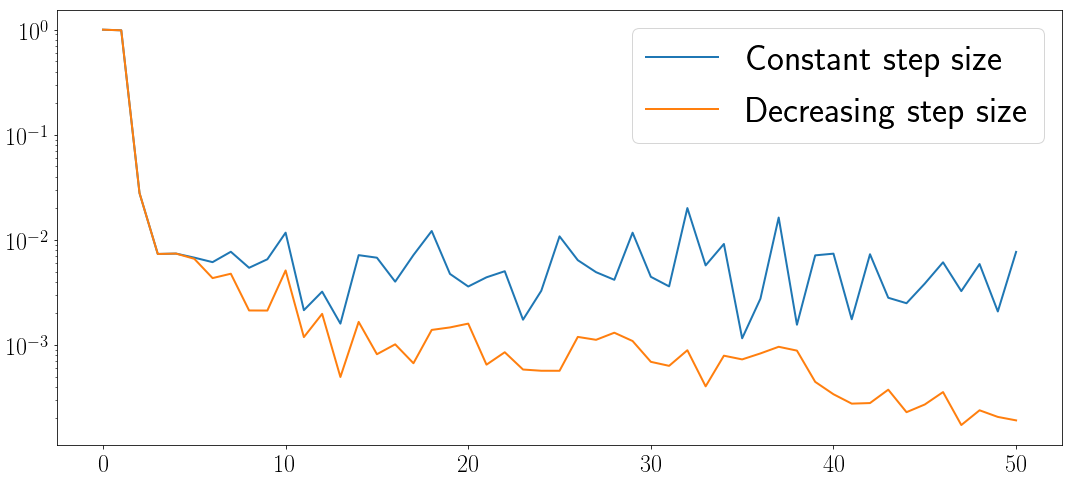

In [110]:
plt.figure(figsize=(18, 8))
plt.semilogy(x_err_const / la.norm(x_0 - x_star)**2, label='Constant step size')
plt.semilogy(x_err_adapt / la.norm(x_0 - x_star)**2, label='Decreasing step size')
plt.legend()
plt.show()

In [125]:
import pickle

In [127]:
# with open('ridge_abalone.pickle', 'wb') as f:
#     pickle.dump([[x_const, 
#                   (f_vals_const - f_ridge(A, y, x_star, lambd)) / (f_ridge(A, y, x_0, lambd) - f_ridge(A, y, x_star, lambd)), 
#                   x_err_const / la.norm(x_0 - x_star)**2],
#                  [x_adapt, 
#                   (f_vals_adapt - f_ridge(A, y, x_star, lambd)) / (f_ridge(A, y, x_0, lambd) - f_ridge(A, y, x_star, lambd)), 
#                   x_err_adapt / la.norm(x_0 - x_star)**2]], f)

# scalings = {}
# with open('ridge_abalone.pickle', 'rb') as f:
#     [[x_const, f_vals_const_scaled, x_err_const_scaled],
#      [x_adapt, f_vals_adapt_scaled, x_err_adapt_scaled]] = pickle.load(f)

In [132]:
# Plot display settings

#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 36#24
plt.rcParams['ytick.labelsize'] = 36#24
plt.rcParams['legend.fontsize'] = 36#24
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 42#36
plt.rcParams['axes.labelsize'] = 36#24

plt.rc('text', usetex=True)

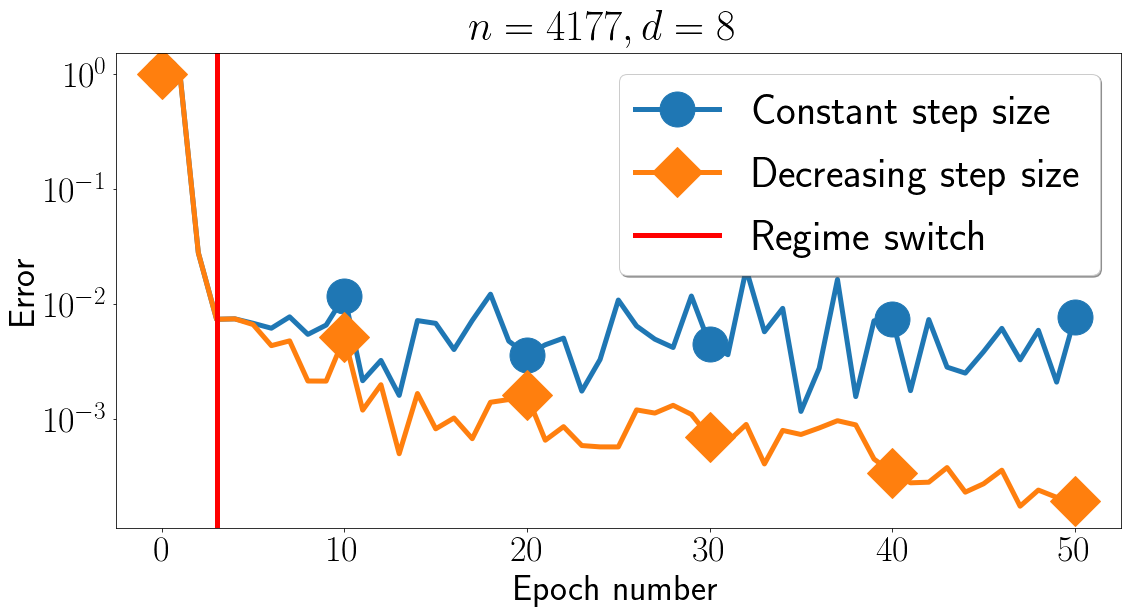

In [133]:
"""PLOTTING"""
fig = plt.figure(figsize=(18, 8))
# plt.title(r"$n = {}, d = {}$".format(n_2, d_2), fontsize=42)
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=42)

# plt.subplot(1, 2, 1)

plt.semilogy(x_err_const / la.norm(x_0 - x_star)**2, label='Constant step size', 
             marker='o', markersize=35, markevery=10, linewidth=5)

plt.semilogy(x_err_adapt / la.norm(x_0 - x_star)**2, label='Decreasing step size', 
             marker='D', markersize=35, markevery=10, linewidth=5)

plt.axvline(k_switch, color='r', linewidth=5, label="Regime switch")

# plt.axhline(nbrhd_region_size / la.norm(x_0 - x_star)**2, 
#             color='g', linestyle='--', linewidth=5, label="Neighborhood region") # label=r"$\frac{2 \gamma \sigma^2}{\mu}$"
#     plt.axvline(k_switch, color='r')#, label=r"$4 \lceil \mathcal{K} \rlceil$")
#     trans = transforms.blended_transform_factory(plt.get_yticklabels()[0].get_transform(), plt.transData)
#     plt.text(k_switch, 0, "{:.0f}".format(k_switch), color="red", transform=trans)#, ha="right", va="center")
plt.xlabel("Epoch number")
plt.ylabel("Error") #  r"$\|x_k - x^*\|^2$

# plt.xlim((0, 150))
# plt.grid()
plt.minorticks_off()
# plt.title(r"$n = {}, d = {}$".format(n_1, d_1), y=1.01, fontsize=24)#, fontsize=36)
plt.legend(loc='best', shadow=True, fontsize=42)

# plt.subplot(1, 2, 2)

# plt.semilogy(x_err_const_2, label='Constant step size')
# plt.semilogy(x_err_adapt_2, label='Decreasing step size')
# #     plt.semilogy(x_err_const / la.norm(x_0 - x_star)**2, label='Constant step size')
# #     plt.semilogy(x_err_adapt / la.norm(x_0 - x_star)**2, label='Decreasing step size')
# #     plt.axvline(k_switch, color='r', label="Regime switch")
# plt.axhline(nbrhd_region_size, color='r', linestyle='--', label="Neighborhood region") # label=r"$\frac{2 \gamma \sigma^2}{\mu}$"
# #     plt.fill_between()
# #     plt.axvline(k_switch, color='r')#, label=r"$4 \lceil \mathcal{K} \rlceil$")
# #     trans = transforms.blended_transform_factory(plt.get_yticklabels()[0].get_transform(), plt.transData)
# #     plt.text(k_switch, 0, "{:.0f}".format(k_switch), color="red", transform=trans)#, ha="right", va="center")
# plt.xlabel("Epoch number: $k$")
# plt.ylabel("Error: "r"$\|x_k - x^*\|^2$")
# plt.xlim((0, max_epoch_2))
# plt.title(r"$n = {}, d = {}$".format(n_2, d_2), y=1.01, fontsize=24)#, fontsize=36)
# plt.grid()
# plt.minorticks_off()
# plt.legend(loc='best', shadow=True)

st.set_y(1.03)
fig.subplots_adjust(top=0.95)
# plt.tight_layout()
plt.savefig('constant_vs_decreasing_ss-abalone_without.pdf', bbox_inches='tight')
plt.show()